<a href="https://colab.research.google.com/github/oraziotorre/MomentumShiftAI/blob/main/ModelsDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

In [76]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("tennis.csv")

In [77]:
# Split 'Pts'
dataset[['Pt1_raw', 'Pt2_raw']] = dataset['Pts'].astype(str).str.split('-', expand=True)

# Set numerici
dataset['Gm1'] = pd.to_numeric(dataset['Gm1'], errors='coerce')
dataset['Gm2'] = pd.to_numeric(dataset['Gm2'], errors='coerce')

# Maschera tiebreak SOLO se 6-6
is_tiebreak = (dataset['Gm1'] == 6) & (dataset['Gm2'] == 6)

normal_score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
tiebreak_score_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, 'AD': 7}

pt1_normal = dataset['Pt1_raw'].map(normal_score_map)
pt2_normal = dataset['Pt2_raw'].map(normal_score_map)

pt1_tb = dataset['Pt1_raw'].map(tiebreak_score_map)
pt2_tb = dataset['Pt2_raw'].map(tiebreak_score_map)

dataset['Pt1'] = np.where(is_tiebreak, pt1_tb, pt1_normal)
dataset['Pt2'] = np.where(is_tiebreak, pt2_tb, pt2_normal)

# Definisci IsDeuce per game normale
normal_deuce = (
    (~is_tiebreak) &
    (
        ((dataset['Pt1'] == 3) & (dataset['Pt2'] == 3)) |   # 40-40
        ((dataset['Pt1'] == 3) & (dataset['Pt2'] == 4)) |   # 40-ADV
        ((dataset['Pt1'] == 4) & (dataset['Pt2'] == 3))     # ADV-40
    )
)

# Definisci IsDeuce per tiebreak
tiebreak_deuce = (
    (is_tiebreak) &
    (dataset['Pt1'] >= 6) &
    (dataset['Pt2'] >= 6) &
    (abs(dataset['Pt1'] - dataset['Pt2']) <= 1)
)

# Combina i due casi
dataset['IsDeuce'] = (normal_deuce | tiebreak_deuce).astype(int)

# Aggiungi colonna IsTieBreak
dataset['IsTieBreak'] = is_tiebreak.astype(int)

dataset.drop(columns=['Pt1_raw', 'Pt2_raw'], inplace=True)

In [78]:
print(dataset.iloc[1470:1505][['Pts', 'Set1', 'Set2', 'Pt1', 'Pt2', 'IsDeuce','IsTieBreak']])

        Pts  Set1  Set2  Pt1  Pt2  IsDeuce  IsTieBreak
1470    0-0     0     1  0.0  0.0        0           0
1471   0-15     0     1  0.0  1.0        0           0
1472  15-15     0     1  1.0  1.0        0           0
1473  30-15     0     1  2.0  1.0        0           0
1474  30-30     0     1  2.0  2.0        0           0
1475  40-30     0     1  3.0  2.0        0           0
1476  40-40     0     1  3.0  3.0        1           0
1477  AD-40     0     1  4.0  3.0        1           0
1478    0-0     0     1  0.0  0.0        0           0
1479   15-0     0     1  1.0  0.0        0           0
1480  15-15     0     1  1.0  1.0        0           0
1481  15-30     0     1  1.0  2.0        0           0
1482  30-30     0     1  2.0  2.0        0           0
1483  30-40     0     1  2.0  3.0        0           0
1484    0-0     0     1  0.0  0.0        0           1
1485    0-1     0     1  0.0  1.0        0           1
1486    1-1     0     1  1.0  1.0        0           1
1487    1-

In [79]:
dataset = dataset.drop(columns=['PointType','Pts'])#,'Player1','Player2','SetID', 'SetWinner','PtSet'

#**Train-Test split**

In [80]:
# Generazione delle partite inverse per aumentare la dimensione del dataset

def augment_with_symmetric(df: pd.DataFrame) -> pd.DataFrame:
    df_swapped = df.copy()

    # Colonne da swappare a coppie
    swap_pairs = [
        ('Set1', 'Set2'),
        ('Gm1', 'Gm2'),
        ('Pt1', 'Pt2'),
        ('Player1', 'Player2'),
        ('Ranking1', 'Ranking2'),
        ('p1_win_nobreak_point', 'p2_win_nobreak_point'),
        ('p1_win_break_point', 'p2_win_break_point'),
        ('p1_lost_nobreak_point', 'p2_lost_nobreak_point'),
        ('p1_lost_break_point', 'p2_lost_break_point'),
        ('serve_ace_1', 'serve_ace_2'),
        ('serve_miss2_1', 'serve_miss1_2'),
        ('rally_winner_1', 'rally_winner_2'),
        ('rally_forced2_1', 'rally_forced1_2'),
        ('rally_unforced1_2', 'rally_unforced2_1')
    ]
    for col1, col2 in swap_pairs:
        df_swapped[[col1, col2]] = df[[col2, col1]].values

    # Colonne dove 1 <-> 2
    invert_1_2_cols = ['Svr', 'PtWinner', 'SetWinner', 'MatchWinner']
    for col in invert_1_2_cols:
        df_swapped[col] = df[col].replace({1: 2, 2: 1})


    # Aggiunta del suffisso 'simm' a match_id e set_id, se presenti
    for col in ['match_id', 'SetID']:
        if col in df_swapped.columns:
            df_swapped[col] = df_swapped[col].astype(str) + '_simm'

    return pd.concat([df, df_swapped], ignore_index=True)

In [86]:
# 1️⃣ Scaling e Normalizzazione

def preprocess_data(train_data, test_data):
    # Copie di sicurezza
    train_data = train_data.copy()
    test_data = test_data.copy()

    # === 1. Colonne da trasformare ===
    minmax_cols = ['Gm1', 'Gm2', 'Pt1', 'Pt2']
    standard_cols = ['Ranking1', 'Ranking2']
    others = [
    'Svr', 'PtWinner', 'IsDeuce', 'IsTieBreak',
    'p1_win_nobreak_point', 'p2_win_nobreak_point',
    'p1_win_break_point', 'p2_win_break_point',
    'p1_lost_nobreak_point', 'p2_lost_nobreak_point',
    'p1_lost_break_point', 'p2_lost_break_point',
    'serve_ace_1', 'serve_ace_2',
    'serve_miss2_1', 'serve_miss1_2',
    'rally_winner_1', 'rally_winner_2',
    'rally_forced2_1', 'rally_forced1_2',
    'rally_unforced1_2', 'rally_unforced2_1'
    ]

    # === 3. Normalizzazione ===
    minmax_scaler = MinMaxScaler()
    train_data[minmax_cols] = minmax_scaler.fit_transform(train_data[minmax_cols])
    test_data[minmax_cols] = minmax_scaler.transform(test_data[minmax_cols])

    # === 4. Standardizzazione ===
    standard_scaler = StandardScaler()
    train_data[standard_cols] = standard_scaler.fit_transform(train_data[standard_cols])
    test_data[standard_cols] = standard_scaler.transform(test_data[standard_cols])

    feature_cols = minmax_cols + others

    # === 5. Target: conversione [1,2] → [0,1] ===
    target_cols = ['Svr', 'PtWinner', 'SetWinner', 'MatchWinner']
    for col in target_cols:
        train_data = train_data[train_data[col].isin([1, 2])]
        test_data = test_data[test_data[col].isin([1, 2])]
        train_data[col] = train_data[col].astype(int) - 1
        test_data[col] = test_data[col].astype(int) - 1

    # === 6. Conversione finale a float ===
    train_data[feature_cols] = train_data[feature_cols].astype(float)
    test_data[feature_cols] = test_data[feature_cols].astype(float)

    return train_data, test_data, feature_cols

In [82]:
# 2️⃣ Creazione sequenze

def create_sequences(data, feature_cols, target_col='SetWinner'):
    X_sequences = []
    y_labels = []
    lengths = []

    # Ordina i punti all'interno di ciascun match
    data = data.sort_values(['SetID', 'PtSet']).reset_index(drop=True)

    for match_id, df_match in data.groupby('SetID'):
        seq_data = df_match[feature_cols].to_numpy(dtype=np.float32)
        X_seq = torch.tensor(seq_data, dtype=torch.float32)
        X_sequences.append(X_seq)

        # Prende il target del primo punto del match (assunto costante per tutti)
        target_winner = int(df_match[target_col].iloc[0])
        y_labels.append(target_winner)
        lengths.append(len(df_match))

    # Padding delle sequenze
    X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)
    y_tensor = torch.tensor(y_labels, dtype=torch.float)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return X_padded, y_tensor, lengths

In [83]:
# 3️⃣ Pipeline completa + DataLoader

def collate_fn(batch):
    inputs, targets, lengths = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    lengths = torch.stack(lengths)
    sorted_idx = torch.argsort(lengths, descending=True)
    return inputs[sorted_idx], targets[sorted_idx], lengths[sorted_idx]

def prepare_datasets(train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1, random_state=42):
    # Preprocessing dati
    train_proc, test_proc, feature_cols = preprocess_data(train_data, test_data)

    # Split ulteriore del training set in train/validation
    match_ids = train_proc['SetID'].unique()
    train_ids, val_ids = train_test_split(match_ids, test_size=val_split, random_state=random_state)

    train_split = train_proc[train_proc['SetID'].isin(train_ids)]
    val_split = train_proc[train_proc['SetID'].isin(val_ids)]

    # Creazione sequenze per train/val/test
    X_train, y_train, train_lengths = create_sequences(train_split, feature_cols, target_col)
    X_val, y_val, val_lengths = create_sequences(val_split, feature_cols, target_col)
    X_test, y_test, test_lengths = create_sequences(test_proc, feature_cols, target_col)

    # Costruzione dei TensorDataset
    train_dataset = TensorDataset(X_train, y_train, train_lengths)
    val_dataset = TensorDataset(X_val, y_val, val_lengths)
    test_dataset = TensorDataset(X_test, y_test, test_lengths)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, feature_cols

#**Model 1**

Epoch 1/100 | Train Loss: 0.3213 | Val Loss: 0.2453
Epoch 2/100 | Train Loss: 0.2575 | Val Loss: 0.2602
Epoch 3/100 | Train Loss: 0.2485 | Val Loss: 0.2424
Epoch 4/100 | Train Loss: 0.2427 | Val Loss: 0.2338
Epoch 5/100 | Train Loss: 0.2378 | Val Loss: 0.2379
Epoch 6/100 | Train Loss: 0.2378 | Val Loss: 0.2467
Epoch 7/100 | Train Loss: 0.2361 | Val Loss: 0.2245
Epoch 8/100 | Train Loss: 0.2357 | Val Loss: 0.2273
Epoch 9/100 | Train Loss: 0.2340 | Val Loss: 0.2305
Epoch 10/100 | Train Loss: 0.2324 | Val Loss: 0.2260
Epoch 11/100 | Train Loss: 0.2337 | Val Loss: 0.2227
Epoch 12/100 | Train Loss: 0.2319 | Val Loss: 0.2273
Epoch 13/100 | Train Loss: 0.2321 | Val Loss: 0.2263
Epoch 14/100 | Train Loss: 0.2300 | Val Loss: 0.2250
Epoch 15/100 | Train Loss: 0.2306 | Val Loss: 0.2223
Epoch 16/100 | Train Loss: 0.2290 | Val Loss: 0.2241
Epoch 17/100 | Train Loss: 0.2291 | Val Loss: 0.2225
Epoch 18/100 | Train Loss: 0.2287 | Val Loss: 0.2258
Epoch 19/100 | Train Loss: 0.2304 | Val Loss: 0.2345
Ep

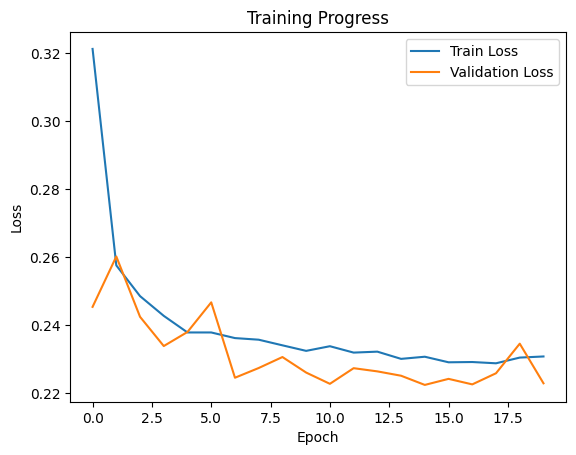

Etichetta vera: 0
Passo 1/88:
Feature: [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]
Probabilità: 0.6460
----------------------------------------
Passo 2/88:
Feature: [0.    0.    0.    0.143 1.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1.    0.   ]
Probabilità: 0.4862
----------------------------------------
Passo 3/88:
Feature: [0.    0.    0.143 0.143 1.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
 0.    0.   ]
Probabilità: 0.5943
----------------------------------------
Passo 4/88:
Feature: [0.    0.    0.143 0.286 1.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
 0.    0.   ]
Probabilità: 0.6698
----------------------------------------
Passo 5/88:
Feature: [0.    0.    0.143 0.429 1.    1.    0.    0.    0.    1.    0.    0.
 0.    0.    0.    0

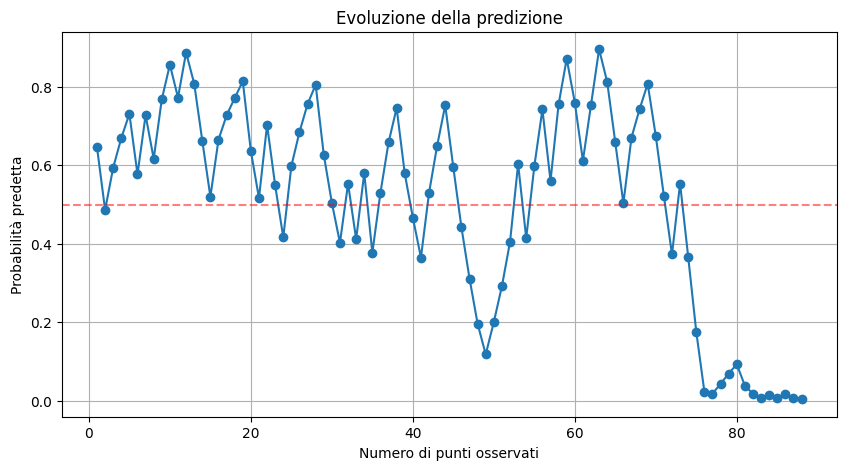

In [88]:
# ---------- 1. MODELLO AGGIORNATO ----------
class LSTMPerStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, lengths, hidden=None):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.dropout(output)
        logits = self.output_layer(output)  # (batch, seq_len, 1)
        probs = torch.sigmoid(logits).squeeze(-1)  # (batch, seq_len)
        return probs, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

# ---------- 2. NUOVA LOSS PESATA ----------
def exponential_weighted_loss(y_pred, y_true, lengths, device, final_weight=10.0):
    """
    Loss che aumenta esponenzialmente il peso verso la fine della sequenza
    """
    batch_size, max_len = y_pred.shape
    weights = torch.ones_like(y_pred, device=device)

    # Crea pesi esponenziali per ogni sequenza nel batch
    for i in range(batch_size):
        L = lengths[i].item()
        # Peso base cresce esponenzialmente verso la fine
        t = torch.arange(0, L, device=device).float()
        sequence_weights = torch.exp(final_weight * (t / L - 1))

        # Normalizza per mantenere l'impatto complessivo simile
        sequence_weights = sequence_weights / sequence_weights.mean()
        weights[i, :L] = sequence_weights

    # Calcola BCE pesata
    loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    weighted_loss = loss * weights

    # Calcola solo sulle posizioni valide
    mask = torch.arange(max_len, device=device)[None, :] < lengths[:, None]
    valid_loss = weighted_loss[mask].mean()

    return valid_loss

# ---------- 3. TRAINING LOOP RIVISTO ----------
def train(model, train_loader, val_loader, optimizer, device, epochs=50, patience=5):
    best_val_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch, lengths in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()

            # Forward pass
            preds, _ = model(X_batch, lengths)

            # Crea target espansi per ogni passo temporale
            y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))

            # Calcola loss
            loss = exponential_weighted_loss(preds, y_expanded, lengths, device)

            # Backpropagazione
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch, lengths in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                lengths = lengths.to(device)

                preds, _ = model(X_batch, lengths)
                y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))
                loss = exponential_weighted_loss(preds, y_expanded, lengths, device)
                val_loss += loss.item()

        # Calcola medie
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Carica il miglior modello
    model.load_state_dict(torch.load('best_model.pth'))
    return history

# ---------- 4. PREDIZIONE EFFICIENTE CON STATO PERSISTENTE ----------
def predict_sequence_steps(model, X_seq, device):
    model.eval()
    X_seq = X_seq.unsqueeze(0).to(device)  # [1, seq_len, input_dim]
    seq_len = X_seq.size(1)
    probs = []

    # Inizializza lo stato nascosto
    hidden = model.init_hidden(1, device)

    with torch.no_grad():
        # Elabora la sequenza incrementale
        for t in range(1, seq_len + 1):
            input_step = X_seq[:, :t, :]
            lengths = torch.tensor([t], dtype=torch.long).to(device)

            # Passa attraverso il modello mantenendo lo stato
            output, hidden = model(input_step, lengths, hidden)
            prob = output[0, -1].item()
            probs.append(prob)

            # Stampa diagnostica
            print(f"Passo {t}/{seq_len}:")
            print(f"Feature: {input_step[0, -1, :].cpu().numpy().round(3)}")
            print(f"Probabilità: {prob:.4f}")
            print("-" * 40)

    return probs

# ---------- 5. ESEMPIO DI UTILIZZO AGGIORNATO ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 26
hidden_size = 64

model = LSTMPerStep(input_size=input_size, hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Preparazione dati (assumendo che 'dataset' sia già definito)
match_ids = dataset['match_id'].unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_data = dataset[dataset['match_id'].isin(train_ids)]
test_data = dataset[dataset['match_id'].isin(test_ids)]

train_data = augment_with_symmetric(train_data)
test_data = augment_with_symmetric(test_data)

# Creazione DataLoader (implementa la tua funzione prepare_datasets)
train_loader, val_loader, test_loader, feature_cols = prepare_datasets(
    train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1
)

# Allenamento
history = train(model, train_loader, val_loader, optimizer, device, epochs=100)

# Plot della loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

# Predizione su una sequenza di test
X_test, y_test, lengths = next(iter(test_loader))
X_seq = X_test[0][:lengths[0]]  # Sequenza completa

print(f"Etichetta vera: {int(y_test[0].item())}")
full_probs = predict_sequence_steps(model, X_seq, device)

# Plot evoluzione probabilità
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(full_probs) + 1), full_probs, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.xlabel("Numero di punti osservati")
plt.ylabel("Probabilità predetta")
plt.title("Evoluzione della predizione")
plt.grid(True)
plt.show()

# **Model 2**

In [100]:
# Importiamo il dataset ottenuto tramite le operazioni di Data Preprocessing
dataset = pd.read_csv("TT.csv")
dataset

,player_id,opponent_id,Set1,Set2,points_progression,SetWinner,MatchWinner,event_match_id,PointWinner,PtSet,Pt,Pts,WonSetP1,WonSetP2,LostSetP1,LostSetP2
0,112463,117294,0,0,2,2,1,1,2,1,1,0-0,0,0,0,0
1,112463,117294,0,0,2,2,1,1,2,2,2,0-1,0,0,0,0
2,112463,117294,0,0,1,2,1,1,1,3,3,0-2,0,0,0,0
3,112463,117294,0,0,1,2,1,1,1,4,4,1-2,0,0,0,0
4,112463,117294,0,0,2,2,1,1,2,5,5,2-2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222644,133652,133850,2,1,1,1,1,19561,1,14,66,8-5,0,0,0,0
1222645,133652,133850,2,1,2,1,1,19561,2,15,67,9-5,0,0,0,0
1222646,133652,133850,2,1,2,1,1,19561,2,16,68,9-6,0,0,0,0
1222647,133652,133850,2,1,1,1,1,19561,1,17,69,9-7,0,0,0,0


In [104]:
# Split 'Pts'
dataset[['Pt1_raw', 'Pt2_raw']] = dataset['Pts'].astype(str).str.split('-', expand=True)

score_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'AD':11}

dataset['Pt1'] = dataset['Pt1_raw'].map(score_map)
dataset['Pt2'] = dataset['Pt2_raw'].map(score_map)
dataset['SetID'] = dataset['event_match_id'].astype(str) + dataset['Set1'].astype(str) + dataset['Set2'].astype(str)


# Definisci IsDeuce per game normale
normal_deuce = (
    (~is_tiebreak) &
    (
        ((dataset['Pt1'] == 10) & (dataset['Pt2'] == 10)) |   # 40-40
        ((dataset['Pt1'] == 11) & (dataset['Pt2'] == 10)) |   # 40-ADV
        ((dataset['Pt1'] == 10) & (dataset['Pt2'] == 11))     # ADV-40
    )
)


# Combina i due casi
dataset['IsDeuce'] = (normal_deuce).astype(int)

dataset.drop(columns=['Pt1_raw', 'Pt2_raw','Pts','point_progression'], inplace=True)

In [105]:
dataset

,player_id,opponent_id,Set1,Set2,points_progression,SetWinner,MatchWinner,event_match_id,PointWinner,PtSet,Pt,WonSetP1,WonSetP2,LostSetP1,LostSetP2,Pt1,Pt2,SetID,IsDeuce
0,112463,117294,0,0,2,2,1,1,2,1,1,0,0,0,0,0,0,100,0
1,112463,117294,0,0,2,2,1,1,2,2,2,0,0,0,0,0,1,100,0
2,112463,117294,0,0,1,2,1,1,1,3,3,0,0,0,0,0,2,100,0
3,112463,117294,0,0,1,2,1,1,1,4,4,0,0,0,0,1,2,100,0
4,112463,117294,0,0,2,2,1,1,2,5,5,0,0,0,0,2,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222644,133652,133850,2,1,1,1,1,19561,1,14,66,0,0,0,0,8,5,1956121,0
1222645,133652,133850,2,1,2,1,1,19561,2,15,67,0,0,0,0,9,5,1956121,0
1222646,133652,133850,2,1,2,1,1,19561,2,16,68,0,0,0,0,9,6,1956121,0
1222647,133652,133850,2,1,1,1,1,19561,1,17,69,0,0,0,0,9,7,1956121,0


In [117]:
# Generazione delle partite inverse per aumentare la dimensione del dataset

def augment_with_symmetric(df: pd.DataFrame) -> pd.DataFrame:
    df_swapped = df.copy()

    # Colonne da swappare a coppie
    swap_pairs = [
        ('Set1', 'Set2'),
        ('Pt1', 'Pt2'),
        ('player_id', 'opponent_id'),
        ('WonSetP1', 'WonSetP2'),
        ('LostSetP1', 'LostSetP2'),
        ('player_id',	'opponent_id')
    ]

    for col1, col2 in swap_pairs:
        df_swapped[[col1, col2]] = df[[col2, col1]].values

    # Colonne dove 1 <-> 2
    invert_1_2_cols = ['PointWinner', 'SetWinner', 'MatchWinner']
    for col in invert_1_2_cols:
        df_swapped[col] = df[col].replace({1: 2, 2: 1})


    # Aggiunta del suffisso 'simm' a match_id e set_id, se presenti
    for col in ['event_match_id', 'SetID']:
        if col in df_swapped.columns:
            df_swapped[col] = df_swapped[col].astype(str) + '_simm'

    return pd.concat([df, df_swapped], ignore_index=True)

In [113]:
# 1️⃣ Scaling e Normalizzazione

def preprocess_data(train_data, test_data):
    # Copie di sicurezza
    train_data = train_data.copy()
    test_data = test_data.copy()

    # === 1. Colonne da trasformare ===
    minmax_cols = ['Pt1', 'Pt2']

    others = ['PointWinner','WonSetP1',	'WonSetP2'	,'LostSetP1'	,'LostSetP2', 'IsDeuce']

    # === 2. Altre feature da conservare (numeriche/categoriche già pronte) ===
    exclude_cols = minmax_cols +  others + \
                   ['match_id', 'SetID', 'Player1', 'Player2', 'PtSet', 'SetWinner', 'MatchWinner']

    # === 3. Normalizzazione ===
    minmax_scaler = MinMaxScaler()
    train_data[minmax_cols] = minmax_scaler.fit_transform(train_data[minmax_cols])
    test_data[minmax_cols] = minmax_scaler.transform(test_data[minmax_cols])


    feature_cols = minmax_cols + others

    # === 5. Target: conversione [1,2] → [0,1] ===
    target_cols = ['PointWinner', 'SetWinner', 'MatchWinner']
    for col in target_cols:
        train_data = train_data[train_data[col].isin([1, 2])]
        test_data = test_data[test_data[col].isin([1, 2])]
        train_data[col] = train_data[col].astype(int) - 1
        test_data[col] = test_data[col].astype(int) - 1

    # === 6. Conversione finale a float ===
    train_data[feature_cols] = train_data[feature_cols].astype(float)
    test_data[feature_cols] = test_data[feature_cols].astype(float)

    return train_data, test_data, feature_cols

In [108]:
# 2️⃣ Creazione sequenze

def create_sequences(data, feature_cols, target_col='SetWinner'):
    X_sequences = []
    y_labels = []
    lengths = []

    # Ordina i punti all'interno di ciascun match
    data = data.sort_values(['SetID', 'PtSet']).reset_index(drop=True)

    for match_id, df_match in data.groupby('SetID'):
        seq_data = df_match[feature_cols].to_numpy(dtype=np.float32)
        X_seq = torch.tensor(seq_data, dtype=torch.float32)
        X_sequences.append(X_seq)

        # Prende il target del primo punto del match (assunto costante per tutti)
        target_winner = int(df_match[target_col].iloc[0])
        y_labels.append(target_winner)
        lengths.append(len(df_match))

    # Padding delle sequenze
    X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)
    y_tensor = torch.tensor(y_labels, dtype=torch.float)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return X_padded, y_tensor, lengths
# 3️⃣ Pipeline completa + DataLoader

def collate_fn(batch):
    inputs, targets, lengths = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    lengths = torch.stack(lengths)
    sorted_idx = torch.argsort(lengths, descending=True)
    return inputs[sorted_idx], targets[sorted_idx], lengths[sorted_idx]

def prepare_datasets(train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1, random_state=42):
    # Preprocessing dati
    train_proc, test_proc, feature_cols = preprocess_data(train_data, test_data)

    # Split ulteriore del training set in train/validation
    match_ids = train_proc['SetID'].unique()
    train_ids, val_ids = train_test_split(match_ids, test_size=val_split, random_state=random_state)

    train_split = train_proc[train_proc['SetID'].isin(train_ids)]
    val_split = train_proc[train_proc['SetID'].isin(val_ids)]

    # Creazione sequenze per train/val/test
    X_train, y_train, train_lengths = create_sequences(train_split, feature_cols, target_col)
    X_val, y_val, val_lengths = create_sequences(val_split, feature_cols, target_col)
    X_test, y_test, test_lengths = create_sequences(test_proc, feature_cols, target_col)

    # Costruzione dei TensorDataset
    train_dataset = TensorDataset(X_train, y_train, train_lengths)
    val_dataset = TensorDataset(X_val, y_val, val_lengths)
    test_dataset = TensorDataset(X_test, y_test, test_lengths)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, feature_cols

In [ ]:
# ---------- 1. MODELLO AGGIORNATO ----------
class LSTMPerStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, lengths, hidden=None):
        lengths = lengths.cpu()
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(packed, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.dropout(output)
        logits = self.output_layer(output)  # (batch, seq_len, 1)
        probs = torch.sigmoid(logits).squeeze(-1)  # (batch, seq_len)
        return probs, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

# ---------- 2. NUOVA LOSS PESATA ----------
def exponential_weighted_loss(y_pred, y_true, lengths, device, final_weight=10.0):
    """
    Loss che aumenta esponenzialmente il peso verso la fine della sequenza
    """
    batch_size, max_len = y_pred.shape
    weights = torch.ones_like(y_pred, device=device)

    # Crea pesi esponenziali per ogni sequenza nel batch
    for i in range(batch_size):
        L = lengths[i].item()
        # Peso base cresce esponenzialmente verso la fine
        t = torch.arange(0, L, device=device).float()
        sequence_weights = torch.exp(final_weight * (t / L - 1))

        # Normalizza per mantenere l'impatto complessivo simile
        sequence_weights = sequence_weights / sequence_weights.mean()
        weights[i, :L] = sequence_weights

    # Calcola BCE pesata
    loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    weighted_loss = loss * weights

    # Calcola solo sulle posizioni valide
    mask = torch.arange(max_len, device=device)[None, :] < lengths[:, None]
    valid_loss = weighted_loss[mask].mean()

    return valid_loss

# ---------- 3. TRAINING LOOP RIVISTO ----------
def train(model, train_loader, val_loader, optimizer, device, epochs=50, patience=5):
    best_val_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch, lengths in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()

            # Forward pass
            preds, _ = model(X_batch, lengths)

            # Crea target espansi per ogni passo temporale
            y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))

            # Calcola loss
            loss = exponential_weighted_loss(preds, y_expanded, lengths, device)

            # Backpropagazione
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch, lengths in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                lengths = lengths.to(device)

                preds, _ = model(X_batch, lengths)
                y_expanded = y_batch.unsqueeze(1).repeat(1, preds.size(1))
                loss = exponential_weighted_loss(preds, y_expanded, lengths, device)
                val_loss += loss.item()

        # Calcola medie
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Carica il miglior modello
    model.load_state_dict(torch.load('best_model.pth'))
    return history

# ---------- 4. PREDIZIONE EFFICIENTE CON STATO PERSISTENTE ----------
def predict_sequence_steps(model, X_seq, device):
    model.eval()
    X_seq = X_seq.unsqueeze(0).to(device)  # [1, seq_len, input_dim]
    seq_len = X_seq.size(1)
    probs = []

    # Inizializza lo stato nascosto
    hidden = model.init_hidden(1, device)

    with torch.no_grad():
        # Elabora la sequenza incrementale
        for t in range(1, seq_len + 1):
            input_step = X_seq[:, :t, :]
            lengths = torch.tensor([t], dtype=torch.long).to(device)

            # Passa attraverso il modello mantenendo lo stato
            output, hidden = model(input_step, lengths, hidden)
            prob = output[0, -1].item()
            probs.append(prob)

            # Stampa diagnostica
            print(f"Passo {t}/{seq_len}:")
            print(f"Feature: {input_step[0, -1, :].cpu().numpy().round(3)}")
            print(f"Probabilità: {prob:.4f}")
            print("-" * 40)

    return probs

# ---------- 5. ESEMPIO DI UTILIZZO AGGIORNATO ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 9
hidden_size = 64

model = LSTMPerStep(input_size=input_size, hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Preparazione dati (assumendo che 'dataset' sia già definito)
match_ids = dataset['event_match_id'].unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_data = dataset[dataset['event_match_id'].isin(train_ids)]
test_data = dataset[dataset['event_match_id'].isin(test_ids)]

train_data = augment_with_symmetric(train_data)
test_data = augment_with_symmetric(test_data)

# Creazione DataLoader (implementa la tua funzione prepare_datasets)
train_loader, val_loader, test_loader, feature_cols = prepare_datasets(
    train_data, test_data, target_col='SetWinner', batch_size=32, val_split=0.1
)

# Allenamento
history = train(model, train_loader, val_loader, optimizer, device, epochs=100)

# Plot della loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

# Predizione su una sequenza di test
X_test, y_test, lengths = next(iter(test_loader))
X_seq = X_test[0][:lengths[0]]  # Sequenza completa

print(f"Etichetta vera: {int(y_test[0].item())}")
full_probs = predict_sequence_steps(model, X_seq, device)

# Plot evoluzione probabilità
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(full_probs) + 1), full_probs, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.xlabel("Numero di punti osservati")
plt.ylabel("Probabilità predetta")
plt.title("Evoluzione della predizione")
plt.grid(True)
plt.show()